Генерация данных:

данные с 10 признаками для линейной регрессии, 
для полиномиальной регрессии данные содержат 1 признак, который трансформируется в полином степени 3


In [1]:
from sklearn.datasets import make_regression
from sklearn.preprocessing import PolynomialFeatures
import numpy as np
import pandas as pd
import seaborn as sns

# Генерация данных для линейной регрессии
X_lin, y_lin = make_regression(n_samples=1000, n_features=10, noise=10, random_state=42)
y_lin = y_lin.reshape(-1, 1)

# Генерация данных для полиномиальной регрессии
X_poly, y_poly = make_regression(
    n_samples=1000, n_features=1, noise=20, random_state=42
)
poly = PolynomialFeatures(degree=3)
X_poly = poly.fit_transform(X_poly)
y_poly = y_poly.reshape(-1, 1)

С помощью библиотеки pytorch создает два класса для линейной и полиномиальной регрессии.
используем слой nn.Linear для удобного матричного умножения и инициализации начальных весов.

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim


# Линейная регрессия
class LinearRegressionModel(nn.Module):
    def __init__(self, n_features):
        super().__init__()
        self.linear = nn.Linear(n_features, 1)

    def forward(self, x):
        return self.linear(x)


# Полиномиальная регрессия
class PolynomialRegressionModel(nn.Module):
    def __init__(self, n_features):
        super().__init__()
        self.linear = nn.Linear(n_features, 1)

    def forward(self, x):
        return self.linear(x)

Функция для обучения моделей
Входные данные: x и y, модель для обучения, оптимизатор в нашем случае будет GSD, cretirion - функция потерь(MSE),
размер батча и кол-во эпох
1) Данные конвертируются в формат TensorDataset
2) Создаётся DataLoader для итерации по данным
3) В каждой эпохе итерация по батчам:
Вычисляется предсказание
Считается ошибка (loss)
Выполняется шаг оптимизации

In [3]:
def train_model(X, y, model, optimizer, criterion, batch_size, epochs):
    dataset = torch.utils.data.TensorDataset(
        torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)
    )
    dataloader = torch.utils.data.DataLoader(
        dataset, batch_size=batch_size, shuffle=True
    )

    losses = []
    for epoch in range(epochs):
        epoch_loss = 0
        for batch_X, batch_y in dataloader:
            optimizer.zero_grad() # Сброс градиентов
            outputs = model(batch_X) # Предсказания модели
            loss = criterion(outputs, batch_y) # Вычисление потерь
            loss.backward() # Вычисление градиентов
            optimizer.step() # Обновление параметров модели
            epoch_loss += loss.item() # Сохранение потерь
        losses.append(epoch_loss / len(dataloader))
    return model, losses

Для линейной регрессии исследуется влияние размеров батча на сходимость модели.
Для каждого размера батча модель обучается, а значение ошибки по эпохам сохраняется.
График показывает, как быстро модели сходятся при разных размерах батча.

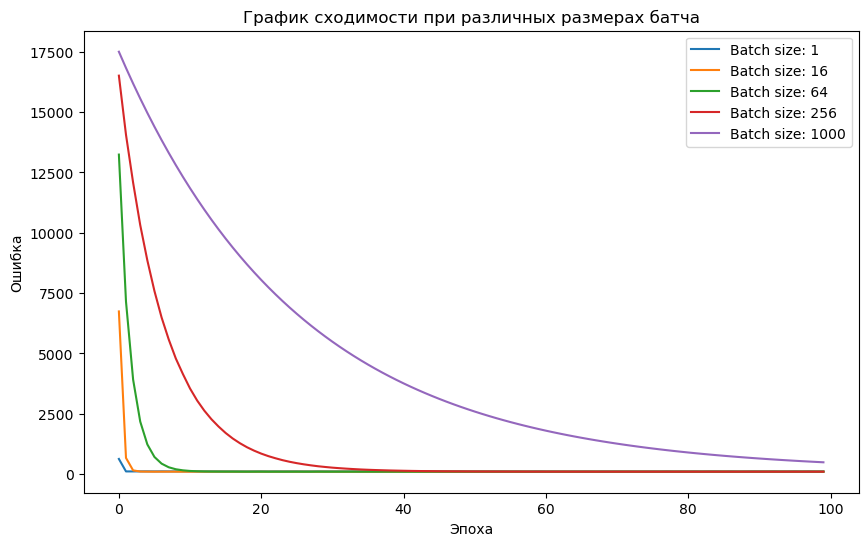

In [5]:
# Параметры
batch_sizes = [1, 16, 64, 256, len(X_lin)]  # От 1 до полного размера
learning_rate = 0.01
epochs = 100

# Результаты
results_batch = {}

for batch_size in batch_sizes:
    model = LinearRegressionModel(X_lin.shape[1])
    criterion = nn.MSELoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)

    model, losses = train_model(
        X_lin, y_lin, model, optimizer, criterion, batch_size, epochs
    )
    results_batch[batch_size] = losses

# График сходимости
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
for batch_size, losses in results_batch.items():
    plt.plot(losses, label=f"Batch size: {batch_size}")
plt.xlabel("Эпоха")
plt.ylabel("Ошибка")
plt.title("График сходимости при различных размерах батча")
plt.legend()
plt.show()

Используется L2-регуляризация через параметр weight_decay в оптимизаторе SGD
График демонстрирует различия в сходимости модели с и без регуляризации.
scheduler_types: список типов планировщиков.
results_scheduler: словарь, где сохраняются потери для каждого планировщика.
gamma: коэффициент уменьшения скорости обучения.
step_size: количество эпох между уменьшениями скорости обучения (для StepLR).
Инициализация планировщика:

Если constant: планировщик не используется (α остаётся постоянной).
Если exponential: скорость обучения уменьшается экспоненциально.
Если step: скорость обучения уменьшается каждые 10 эпох.
Цикл обучения:
На каждой эпохе выполняется одна итерация обучения (train_model).
Если используется планировщик, то в конце каждой эпохи вызывается scheduler.step(), чтобы обновить скорость обучения.
Потери (losses) для каждого планировщика сохраняются в словарь results_scheduler

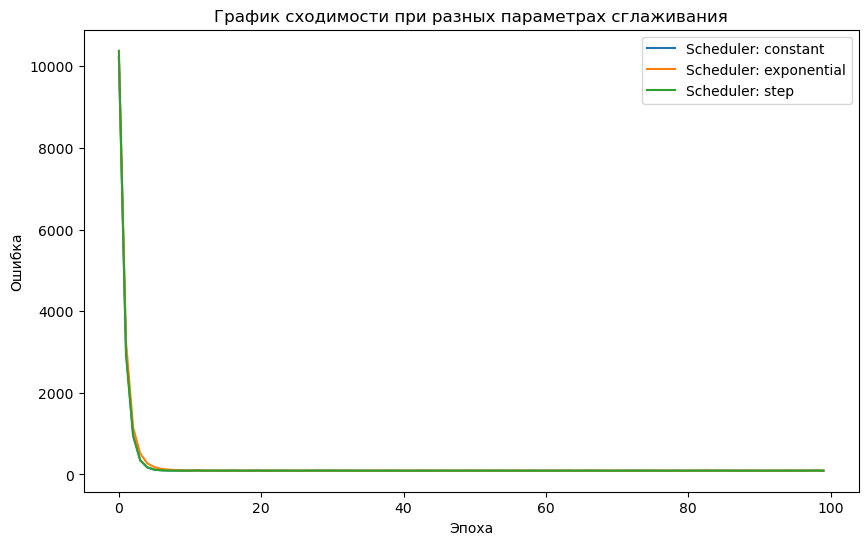

In [6]:
scheduler_types = ["constant", "exponential", "step"]
results_scheduler = {}

for scheduler_type in scheduler_types:
    model = LinearRegressionModel(X_lin.shape[1])
    criterion = nn.MSELoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)

    if scheduler_type == "constant":
        scheduler = None
    elif scheduler_type == "exponential":
        scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
    elif scheduler_type == "step":
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

    losses = []
    for epoch in range(epochs):
        model, epoch_losses = train_model(
            X_lin, y_lin, model, optimizer, criterion, batch_size=32, epochs=1
        )
        losses.extend(epoch_losses)
        if scheduler:
            scheduler.step()
    results_scheduler[scheduler_type] = losses

# График сходимости
plt.figure(figsize=(10, 6))
for sched_type, losses in results_scheduler.items():
    plt.plot(losses, label=f"Scheduler: {sched_type}")
plt.xlabel("Эпоха")
plt.ylabel("Ошибка")
plt.title("График сходимости при разных параметрах сглаживания")
plt.legend()
plt.show()

Сравнение работы с использованием разных оптимизаторов
Для каждого оптимизатора создается новая линейная модель LinearRegressionModel
Обучение модели выполняется с фиксированными параметрами: batch_size=32, количество эпох = 100
Потери на каждой эпохе сохраняются в словарь results_optimizers
график сравнивает, как быстро каждая оптимизация уменьшает функцию потерь


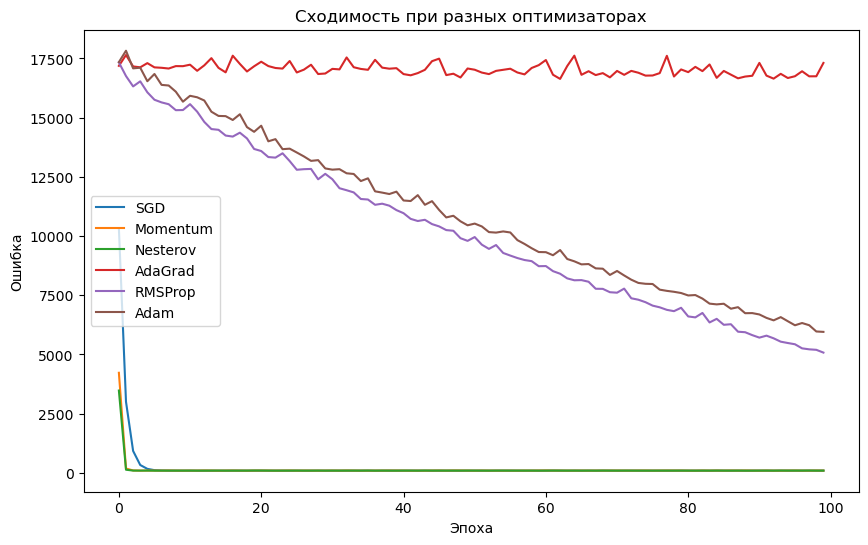

In [9]:
optimizers = {
    "SGD": lambda params: optim.SGD(params, lr=learning_rate),
    "Momentum": lambda params: optim.SGD(params, lr=learning_rate, momentum=0.9),
    "Nesterov": lambda params: optim.SGD(params, lr=learning_rate, momentum=0.9, nesterov=True),
    "AdaGrad": lambda params: optim.Adagrad(params, lr=learning_rate),
    "RMSProp": lambda params: optim.RMSprop(params, lr=learning_rate),
    "Adam": lambda params: optim.Adam(params, lr=learning_rate),
}

results_optimizers = {}

for name, opt_func in optimizers.items():
    model = LinearRegressionModel(X_lin.shape[1])
    criterion = nn.MSELoss()
    optimizer = opt_func(model.parameters())

    model, losses = train_model(
        X_lin, y_lin, model, optimizer, criterion, batch_size=32, epochs=epochs
    )
    results_optimizers[name] = losses

# График сходимости
plt.figure(figsize=(10, 6))
for name, losses in results_optimizers.items():
    plt.plot(losses, label=name)
plt.xlabel("Эпоха")
plt.ylabel("Ошибка")
plt.title("Сходимость при разных оптимизаторах")
plt.legend()
plt.show()

Тренировка модели с регуляризацией
Здесь обучается полиномиальная регрессия с добавлением регуляризации,
weight_decay=0.01 означает, что штраф за большие веса добавляется к функции потерь
график показывает, как L2-регуляризация влияет на скорость и качество сходимости

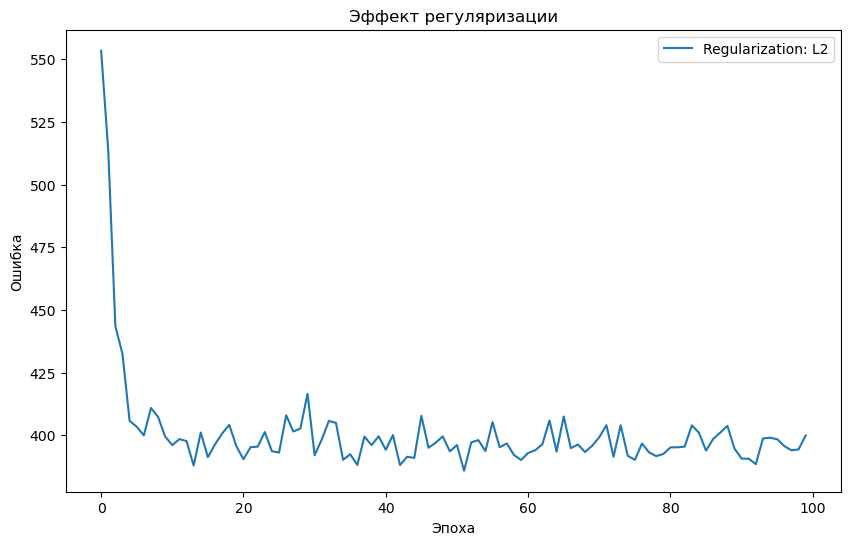

In [10]:
regularizations = {
    "L2": lambda params: optim.SGD(params, lr=learning_rate, weight_decay=0.01),
}

results_regularization = {}

for name, opt_func in regularizations.items():
    model = PolynomialRegressionModel(X_poly.shape[1])
    criterion = nn.MSELoss()
    optimizer = opt_func(model.parameters())

    model, losses = train_model(
        X_poly, y_poly, model, optimizer, criterion, batch_size=32, epochs=epochs
    )
    results_regularization[name] = losses

# График сходимости
plt.figure(figsize=(10, 6))
for name, losses in results_regularization.items():
    plt.plot(losses, label=f"Regularization: {name}")
plt.xlabel("Эпоха")
plt.ylabel("Ошибка")
plt.title("Эффект регуляризации")
plt.legend()
plt.show()